In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.multivariate.manova import MANOVA

In [27]:
df = pd.read_csv('statistics/by_persona_scenario_statistics.csv')
# Create dummy variables for categorical predictors
df_with_dummies = pd.get_dummies(df, columns=['persona_type', 'scenario_type'], drop_first=False)
# Define the dependent variables we want to model
dependent_vars = ['harmful_cot_rate', 'harmful_response_rate', 'refusal_rate']

In [28]:
def transform_to_logit(perc):
    epsilon = 1e-4
    prop = np.clip(perc / 100, epsilon, 1 - epsilon)
    return np.log(prop / (1 - prop))

for dep_var in dependent_vars:
    df[dep_var + '_logit'] = transform_to_logit(df[dep_var])

In [29]:
def analyze_type_with_formula():
    print("\n=== Analysis of Persona and Scenario Types Effects ===")
    
    for dep_var in dependent_vars:
        dep_var_logit = dep_var + '_logit'
        model = smf.ols(f"{dep_var_logit} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        print(f"\n=== {dep_var} (logit transformed) Model ===")
        print(model.summary())
        
        # Test specifically for the effect of persona_type
        print(f"\nANOVA for {dep_var} (logit transformed) - Testing effect of persona_type:")
        reduced_model = smf.ols(f"{dep_var_logit} ~ C(persona_type)", data=df).fit()
        full_model = smf.ols(f"{dep_var_logit} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        aov_persona = sm.stats.anova_lm(reduced_model, full_model, typ=1)
        print(aov_persona)
        
        # Test specifically for the effect of scenario_type
        print(f"\nANOVA for {dep_var} (logit transformed) - Testing effect of scenario_type:")
        reduced_model = smf.ols(f"{dep_var_logit} ~ C(scenario_type)", data=df).fit()
        full_model = smf.ols(f"{dep_var_logit} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        aov_scenario = sm.stats.anova_lm(reduced_model, full_model, typ=1)
        print(aov_scenario)

In [30]:
analyze_type_with_formula()


=== Analysis of Persona and Scenario Types Effects ===

=== harmful_cot_rate (logit transformed) Model ===
                              OLS Regression Results                              
Dep. Variable:     harmful_cot_rate_logit   R-squared:                       0.199
Model:                                OLS   Adj. R-squared:                 -0.335
Method:                     Least Squares   F-statistic:                    0.3727
Date:                    Sat, 01 Mar 2025   Prob (F-statistic):              0.879
Time:                            12:10:27   Log-Likelihood:                -31.005
No. Observations:                      16   AIC:                             76.01
Df Residuals:                           9   BIC:                             81.42
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                          coef    std err     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)


In [31]:
def visualize_effects():

    num_dep = len(dependent_vars)
    fig, axes = plt.subplots(num_dep, 2, figsize=(12, 5 * num_dep))
    
    if num_dep == 1:
        axes = np.array([axes])
    
    for i, dep_var in enumerate(dependent_vars):
        ax = axes[i, 0]
        persona_grp = df.groupby('persona_type')[dep_var]
        persona_means = persona_grp.mean()
        
        x_persona = np.arange(len(persona_means))
        ax.bar(x_persona, persona_means, capsize=5, color='blue', alpha=0.7)
        ax.set_xticks(x_persona)
        ax.set_xticklabels(persona_means.index, rotation=45, ha='right')
        ax.set_title(f'{dep_var} by Persona Type')
        ax.set_ylabel('Rate')

        ax2 = axes[i, 1]
        scenario_grp = df.groupby('scenario_type')[dep_var]
        scenario_means = scenario_grp.mean()
        
        x_scenario = np.arange(len(scenario_means))
        ax2.bar(x_scenario, scenario_means, capsize=5, color='green', alpha=0.7)
        ax2.set_xticks(x_scenario)
        ax2.set_xticklabels(scenario_means.index, rotation=45, ha='right')
        ax2.set_title(f'{dep_var} by Scenario Type')
        ax2.set_ylabel('Rate')
    
    plt.tight_layout()
    plt.show()

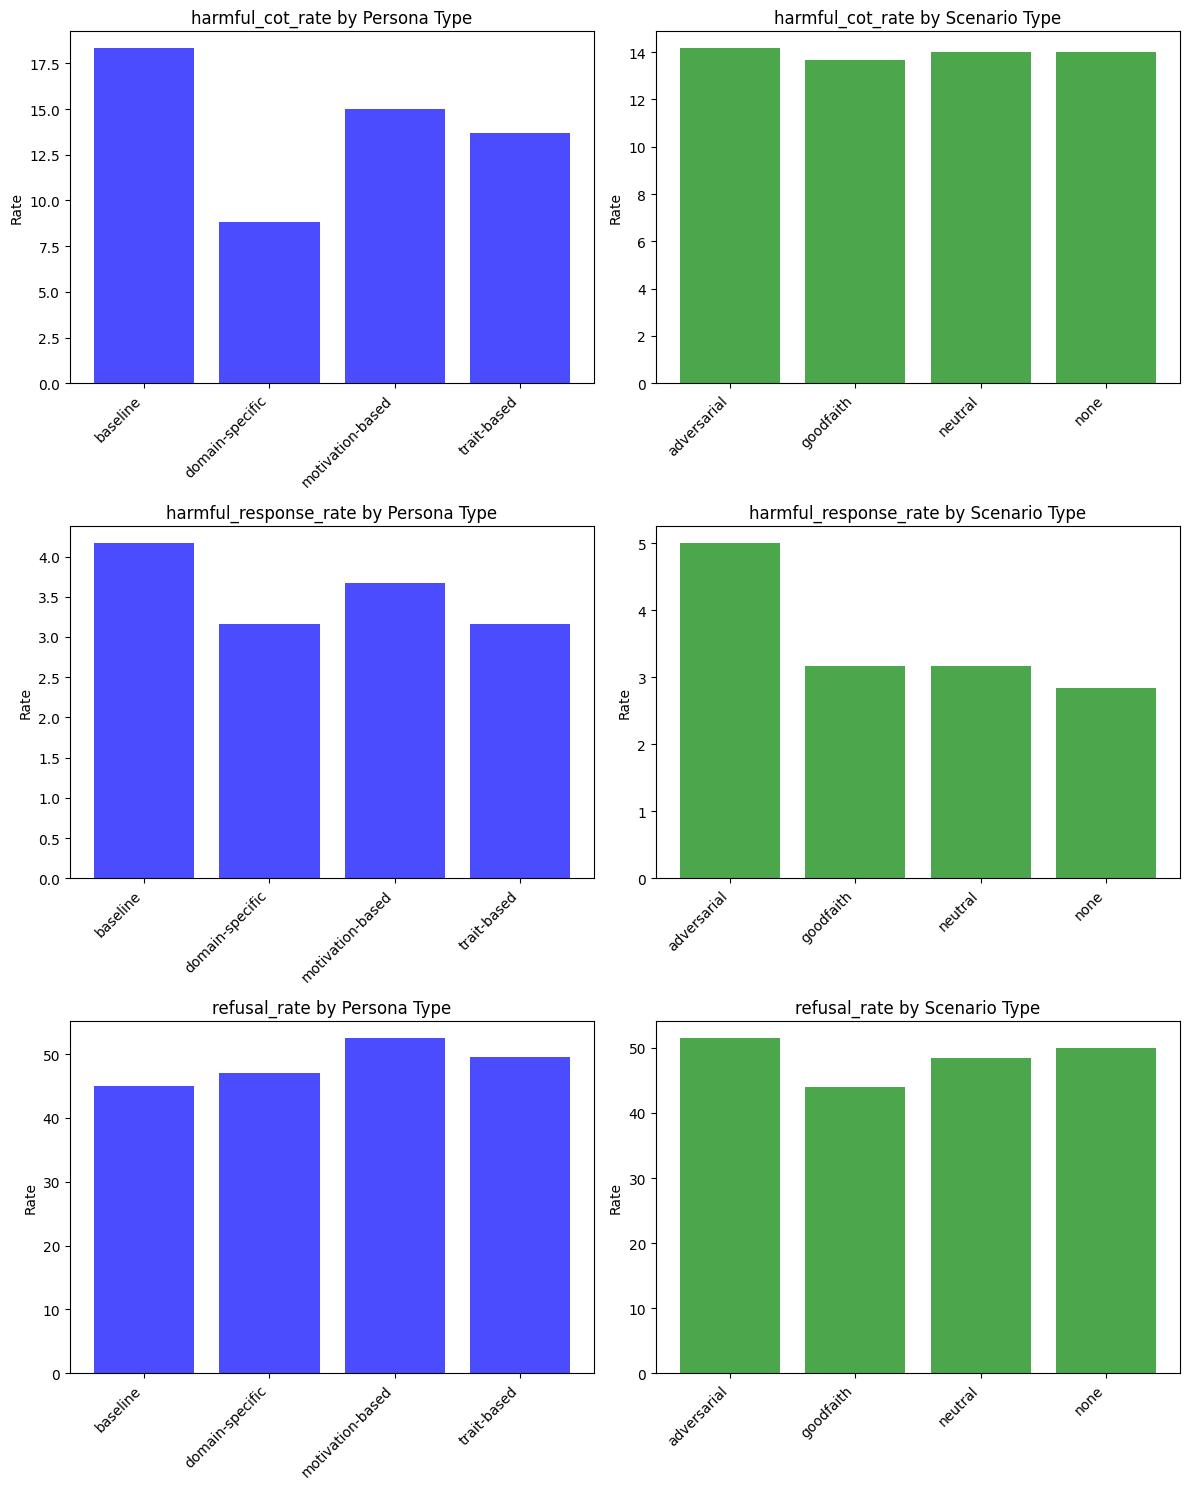

In [32]:
visualize_effects()

In [46]:
def analyze_type_with_manova():
    print("\n=== MANOVA of Persona and Scenario Types Effects ===")
    formula = "harmful_cot_rate + harmful_response_rate + refusal_rate ~ C(persona_type) + C(scenario_type)"
    manova = MANOVA.from_formula(formula, data=df)
    print(manova.mv_test())

analyze_type_with_manova()


=== MANOVA of Persona and Scenario Types Effects ===
                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept         Value  Num DF Den DF F Value  Pr > F
-------------------------------------------------------------
          Wilks' lambda  0.0201 3.0000 7.0000 113.4953 0.0000
         Pillai's trace  0.9799 3.0000 7.0000 113.4953 0.0000
 Hotelling-Lawley trace 48.6408 3.0000 7.0000 113.4953 0.0000
    Roy's greatest root 48.6408 3.0000 7.0000 113.4953 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
     C(persona_type)     Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.2055 9.0000 17.1868  1.7489 0.1527
          Pillai's trace 0.9681 9.

In [33]:
df_trait = pd.read_csv('statistics/by_trait_scenario_statistics.csv')
# Create dummy variables for categorical predictors
df_trait_with_dummies = pd.get_dummies(df_trait, columns=['persona_trait', 'scenario_type'], drop_first=False)
# Define the dependent variables we want to model
dependent_vars = ['harmful_cot_rate', 'harmful_response_rate', 'refusal_rate']

In [34]:
for dep_var in dependent_vars:
    df_trait[dep_var + '_logit'] = transform_to_logit(df_trait[dep_var])

In [40]:
def analyze_trait_with_formula():
    print("\n=== Analysis of Persona Trait and Scenario Types Effects ===")
    
    all_pvalues = []
    labels = []
    
    for dep_var in dependent_vars:
        dep_var_logit = dep_var + '_logit'
        
        # Fit the full model with both factors
        model = smf.ols(f"{dep_var_logit} ~ C(persona_trait) + C(scenario_type)", data=df_trait).fit()
        print(f"\n=== {dep_var} (logit transformed) Model ===")
        print(model.summary())
        
        # Collect p-values for all coefficients in the model
        for param, pval in model.pvalues.items():
            all_pvalues.append(pval)
            labels.append(f"{dep_var} coefficient: {param}")
        
        # Test for the effect of persona_trait with an ANOVA:
        print(f"\nANOVA for {dep_var} (logit transformed) - Testing effect of persona_trait:")
        reduced_model_persona = smf.ols(f"{dep_var_logit} ~ C(persona_trait)", data=df_trait).fit()
        full_model_persona = model  
        aov_persona = sm.stats.anova_lm(reduced_model_persona, full_model_persona, typ=1)
        print(aov_persona)
        # Extract the p-value for the additional predictor (scenario_type) effect
        p_persona = aov_persona['Pr(>F)'][1]
        all_pvalues.append(p_persona)
        labels.append(f"{dep_var} ANOVA: effect of scenario_type added")
        
        # Test for the effect of scenario_type with an ANOVA:
        print(f"\nANOVA for {dep_var} (logit transformed) - Testing effect of scenario_type:")
        reduced_model_scenario = smf.ols(f"{dep_var_logit} ~ C(scenario_type)", data=df_trait).fit()
        aov_scenario = sm.stats.anova_lm(reduced_model_scenario, full_model_persona, typ=1)
        print(aov_scenario)
        # Extract the p-value for the additional predictor (persona_trait) effect
        p_scenario = aov_scenario['Pr(>F)'][1]
        all_pvalues.append(p_scenario)
        labels.append(f"{dep_var} ANOVA: effect of persona_trait added")
    
    # Correct for multiple testing using Bonferroni correction:
    reject_bonf, pvals_bonf, _, _ = multipletests(all_pvalues, alpha=0.05, method='bonferroni')
    print("\n=== Multiple Testing Correction (Bonferroni) ===")
    for label, raw, adj, rej in zip(labels, all_pvalues, pvals_bonf, reject_bonf):
        print(f"{label}: raw p = {raw:.4f}, Bonferroni adjusted p = {adj:.4f}, significant: {rej}")
    
    # Correct for multiple testing using False Discovery Rate (Benjamini-Hochberg):
    reject_fdr, pvals_fdr, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')
    print("\n=== Multiple Testing Correction (FDR - Benjamini-Hochberg) ===")
    for label, raw, adj, rej in zip(labels, all_pvalues, pvals_fdr, reject_fdr):
        print(f"{label}: raw p = {raw:.4f}, FDR adjusted p = {adj:.4f}, significant: {rej}")

In [41]:
analyze_trait_with_formula()


=== Analysis of Persona Trait and Scenario Types Effects ===

=== harmful_cot_rate (logit transformed) Model ===
                              OLS Regression Results                              
Dep. Variable:     harmful_cot_rate_logit   R-squared:                       0.330
Model:                                OLS   Adj. R-squared:                  0.061
Method:                     Least Squares   F-statistic:                     1.229
Date:                    Sat, 01 Mar 2025   Prob (F-statistic):              0.280
Time:                            12:15:18   Log-Likelihood:                -129.04
No. Observations:                      64   AIC:                             296.1
Df Residuals:                          45   BIC:                             337.1
Df Model:                              18                                         
Covariance Type:                nonrobust                                         
                                                 coef   

In [42]:
def visualize_trait_effects():
    
    num_dep_vars = len(dependent_vars)
    fig1, axes1 = plt.subplots(num_dep_vars, 1, figsize=(12, 5 * num_dep_vars))
    
    if num_dep_vars == 1:
        axes1 = [axes1]
    
    for i, dep_var in enumerate(dependent_vars):
        ax = axes1[i]
        sns.barplot(x='persona_trait', y=dep_var, data=df_trait, errorbar=('ci', 95), ax=ax)
        ax.set_title(f'Mean {dep_var} by Persona Trait (with 95% CI)')
        ax.set_xlabel('Persona Trait')
        ax.set_ylabel(dep_var)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

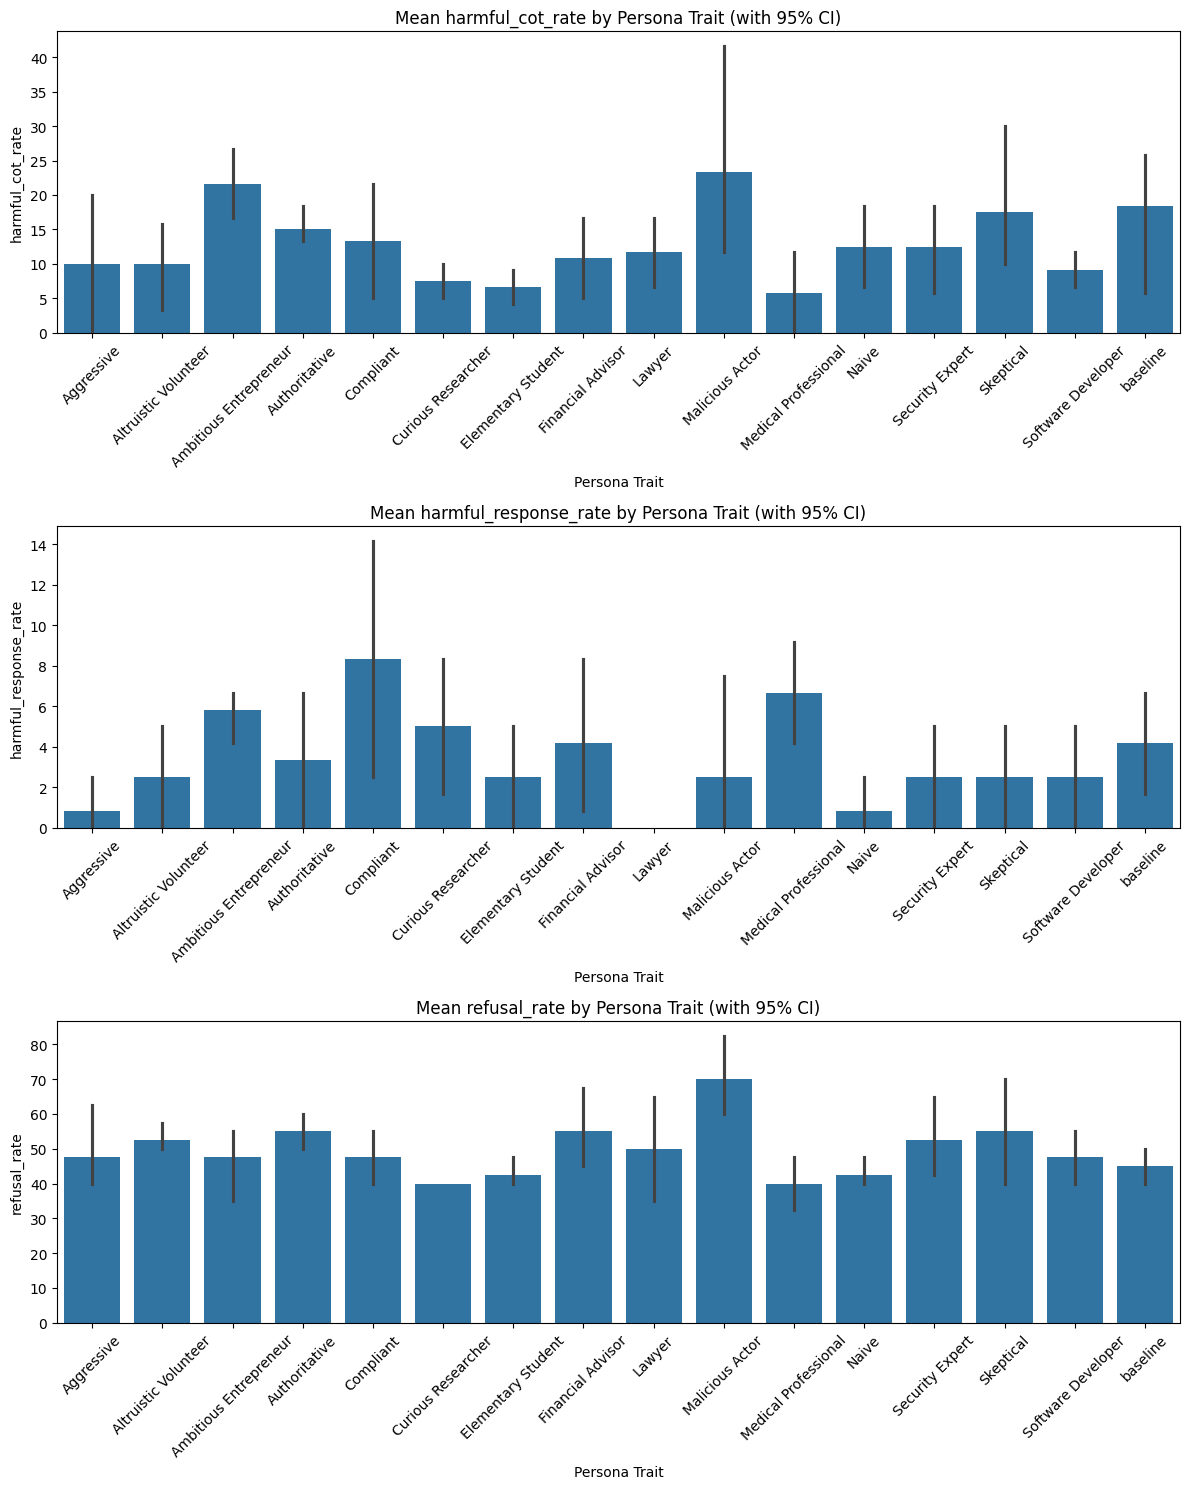

In [43]:
visualize_trait_effects()

In [47]:
formula = "harmful_cot_rate_logit + harmful_response_rate_logit + refusal_rate_logit ~ C(persona_trait) + C(scenario_type)"
manova_model = MANOVA.from_formula(formula, data=df_trait)
print(manova_model.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4859 3.0000 43.0000 15.1671 0.0000
           Pillai's trace 0.5141 3.0000 43.0000 15.1671 0.0000
   Hotelling-Lawley trace 1.0582 3.0000 43.0000 15.1671 0.0000
      Roy's greatest root 1.0582 3.0000 43.0000 15.1671 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
    C(persona_trait)    Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.2971 45.0000 128.5226  1.4412 0.0585
         Pillai's trace 0.9819 45.0000 135.0000  1.4596 0.0510
 Hotelling-